In [1]:
# To stop  displaying warning messages in output
import warnings
warnings.filterwarnings('ignore')
# To  collect garbage (delete files)
import gc
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
# for basic math operations like sqrt
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')
from math import sin, cos, sqrt, atan2, radians

In [2]:
%matplotlib inline

In [3]:
input_data = pd.read_csv("/kaggle/input/rapido/ct_rr_subset.xls")
input_data.shape

(100000, 6)

In [4]:
print("Data size before removing: ",input_data.shape)

# Check duplicated rows in train set
df = input_data[input_data.duplicated()]  # checks duplicate rows considering all columns
print("Number of duplicate observations: ", len(df))
del df
gc.collect();

#Dropping duplicates and keeping first occurence only
input_data.drop_duplicates(keep = 'first', inplace = True)

print("Data size after removing: ",input_data.shape)

Data size before removing:  (100000, 6)
Number of duplicate observations:  716
Data size after removing:  (99284, 6)


In [5]:
input_data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


In [6]:
print("Number of unique customers: " ,input_data["number"].nunique()) #number of distinct customers = 1.7 lakhs

Number of unique customers:  14461


The number of customers are 14 k. Therefore,it won't be practically feasible to predict forecast for each customer. So, we can drop that column.

Converting timestamp to month number, year number etc

In [7]:
# new data frame with split value columns 
new = input_data["ts"].str.split(" ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
input_data["raw_date"]= new[0] 
  
# making separate last name column from new data frame 
input_data["raw_time"]= new[1] 

input_data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29


In [8]:
# new data frame with split value columns 
new = input_data["raw_date"].str.split("-", n = 2, expand = True) 
  
# making separate first name column from new data frame 
input_data["year"]= new[0] 
  
# making separate last name column from new data frame 
input_data["month"]= new[1] 

# making separate last name column from new data frame 
input_data["date"]= new[2] 

input_data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time,year,month,date
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17,2018,04,07
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27,2018,04,07
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44,2018,04,07
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00,2018,04,07
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29,2018,04,07


In [9]:
# new data frame with split value columns 
new = input_data["raw_time"].str.split(":", n = 2, expand = True) 
  
# making separate first name column from new data frame 
input_data["hour"]= new[0]
#24:00 time system
  
# making separate last name column from new data frame 
input_data["minute"]= new[1] 

input_data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time,year,month,date,hour,minute
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17,2018,04,07,07,07
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27,2018,04,07,07,32
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44,2018,04,07,07,36
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00,2018,04,07,07,38
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29,2018,04,07,07,39


In [10]:
#removing cols which are not reqd.
data = input_data.copy()
data.drop(["raw_date","raw_time","number","minute"],axis=1, inplace=True)
data.head()

del input_data
gc.collect();

In [11]:
print("Is there any missing value? ",data.isna().sum().sum()>0)

Is there any missing value?  False


In [12]:
def distance(pick_lat, pick_lng, drop_lat, drop_lng):
    
    # approximate radius of earth in km
    R = 6373.0
    
    s_lat = pick_lat*np.pi/180.0                      
    s_lng = np.deg2rad(pick_lng)     
    e_lat = np.deg2rad(drop_lat)                       
    e_lng = np.deg2rad(drop_lng)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return round(2 * R * np.arcsin(np.sqrt(d)),1) 

In [13]:
data["distance"] = data.apply(lambda x: distance(x.pick_lat, x.pick_lng, x.drop_lat, x.drop_lng), axis=1)
data.head(3)

,ts,pick_lat,pick_lng,drop_lat,drop_lng,year,month,date,hour,distance
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.60228,2018,04,07,07,6.7
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.54377,2018,04,07,07,2.2
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.56995,2018,04,07,07,4.3


In [14]:
#assuming avg. bike speed of 35km/hrs, we can calculate time in min.
avg_speed = 35/60 #speed in km/minutes
data["ride_minutes"] = data["distance"].apply(lambda x: round(x/avg_speed,0))

print("Maximum ride distance covered in Km: ", data.distance.max())
print("Minimum ride distance covered in Km: ", data.distance.min())
print("Maximum ride time in mins: ",data.ride_minutes.max())
print("Minimum ride time in mins: ", data.ride_minutes.min())

Maximum ride distance covered in Km:  13829.2
Minimum ride distance covered in Km:  0.0
Maximum ride time in mins:  23707.0
Minimum ride time in mins:  0.0


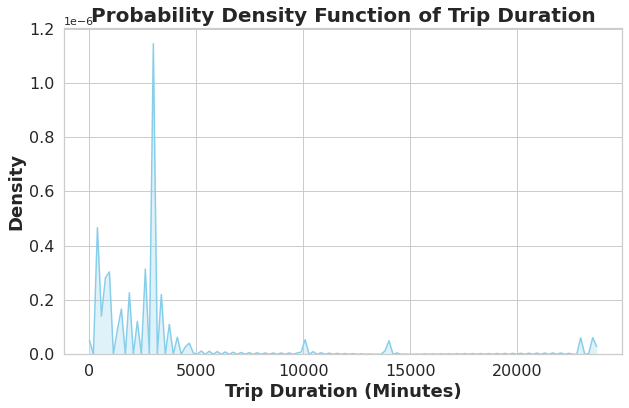

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create the KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data["ride_minutes"].values, shade=True, cumulative=False, color="skyblue")

# Set labels and title with appropriate font sizes
plt.tick_params(labelsize=16)
plt.xlabel("Trip Duration (Minutes)", fontsize=18, fontweight='bold')
plt.ylabel("Density", fontsize=18, fontweight='bold')
plt.title("Probability Density Function of Trip Duration", fontsize=20, fontweight='bold')

# Display the plot
plt.show()


Assuming the data given to us is for india geography only. It will also help to remove outliers that might lie in entering data for lat and long for India geography. Therefore, we can remove invalid latitude and longitudes For India, longitude: (66, 90), latitude: (8, 40)

In [16]:
data = data[(data.pick_lng <90) & (data.drop_lng <90) & (data.pick_lng >66) & (data.drop_lng >66) &
       (data.pick_lat <40) & (data.drop_lat <40) & (data.pick_lat >8) & (data.drop_lat >8)]

data.shape

(99278, 11)

In [17]:
#after removing above outliers based on lat and long

print("Maximum ride distance covered in Km: ", data.distance.max())
print("Minimum ride distance covered in Km: ", data.distance.min())
print("Maximum ride time in mins: ",data.ride_minutes.max())
print("Minimum ride time in mins: ", data.ride_minutes.min())

Maximum ride distance covered in Km:  2320.9
Minimum ride distance covered in Km:  0.0
Maximum ride time in mins:  3979.0
Minimum ride time in mins:  0.0


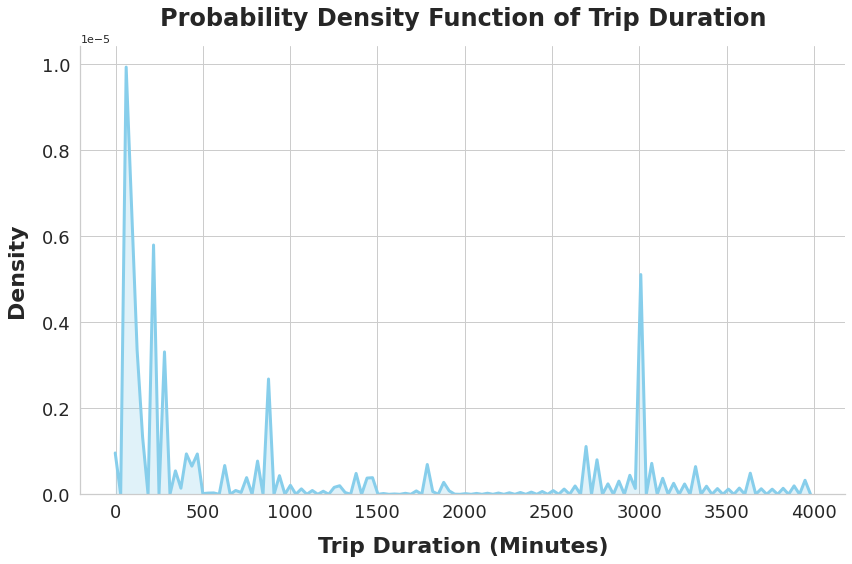

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create the KDE plot with enhanced styling
plt.figure(figsize=(12, 8))
sns.kdeplot(data["ride_minutes"].values, shade=True, cumulative=False, color="skyblue", linewidth=3)

# Set labels and title with improved font sizes and weights
plt.xlabel("Trip Duration (Minutes)", fontsize=22, fontweight='bold', labelpad=15)
plt.ylabel("Density", fontsize=22, fontweight='bold', labelpad=15)
plt.title("Probability Density Function of Trip Duration", fontsize=24, fontweight='bold', pad=20)

# Set ticks with larger font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Remove top and right spines
sns.despine()

# Display the plot
plt.tight_layout()
plt.show()


In [19]:
coord = data[["pick_lat", "pick_lng"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
data["pickup_cluster"] = regions.predict(data[["pick_lat", "pick_lng"]])

In [20]:
import folium

# Function to add cluster markers with custom icon and tooltip
def add_cluster_markers(map_obj, cluster_centers):
    for center in cluster_centers:
        folium.Marker(
            location=[center[0], center[1]],
            icon=folium.Icon(color='blue', icon='info-sign'),
            popup=f"Latitude: {round(center[0], 2)}, Longitude: {round(center[1], 2)}",
            tooltip="Click for more info"
        ).add_to(map_obj)

# Initialize the map
m = folium.Map(location=[12.972442, 77.580643], tiles="Stamen Toner", zoom_start=12)

# Define cluster centers
centerOfRegions = regions.cluster_centers_

# Add cluster markers to the map
add_cluster_markers(m, centerOfRegions)

# Display the map
m


In [21]:
import folium
from sklearn.cluster import MiniBatchKMeans
import numpy as np

# Function to add cluster markers with custom icon and tooltip
def add_cluster_markers(map_obj, cluster_centers):
    for center in cluster_centers:
        folium.Marker(
            location=[center[0], center[1]],
            icon=folium.Icon(color='blue', icon='info-sign'),
            popup=f"Latitude: {round(center[0], 2)}, Longitude: {round(center[1], 2)}"
        ).add_to(map_obj)

# Get cluster centers and initialize the map
coord = data[["drop_lat", "drop_lng"]].values
regions = MiniBatchKMeans(n_clusters=30, batch_size=10000).fit(coord)
centerOfRegions = regions.cluster_centers_
m = folium.Map(location=[12.972442, 77.580643], zoom_start=12)

# Add cluster markers to the map
add_cluster_markers(m, centerOfRegions)

# Display the map
m


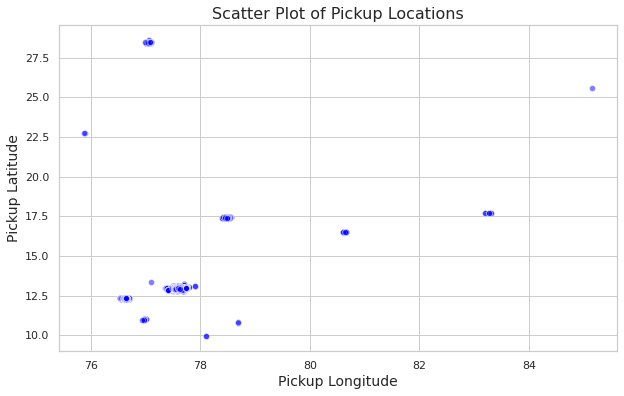

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pick_lng', y='pick_lat', data=data, color='blue', alpha=0.5)

# Set labels and title
plt.xlabel('Pickup Longitude', fontsize=14)
plt.ylabel('Pickup Latitude', fontsize=14)
plt.title('Scatter Plot of Pickup Locations', fontsize=16)

# Show plot
plt.show()


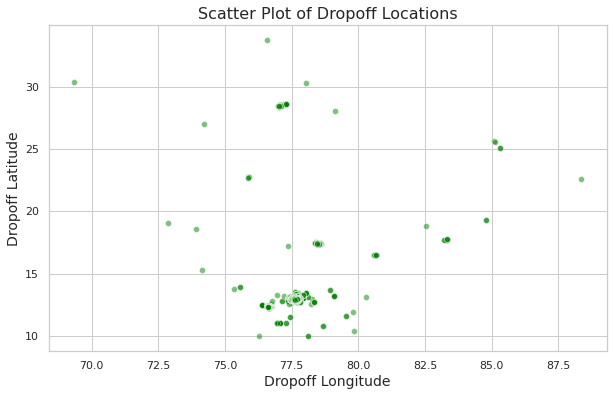

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='drop_lng', y='drop_lat', data=data, color='green', alpha=0.5)

# Set labels and title
plt.xlabel('Dropoff Longitude', fontsize=14)
plt.ylabel('Dropoff Latitude', fontsize=14)
plt.title('Scatter Plot of Dropoff Locations', fontsize=16)

# Show plot
plt.show()


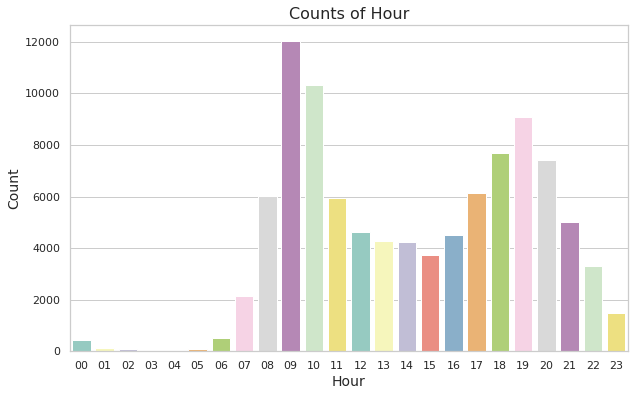

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create count plot
plt.figure(figsize=(10, 6))
sns.countplot(x="hour", data=data, palette="Set3")

# Set labels and title
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Counts of Hour', fontsize=16)

# Show plot
plt.show()


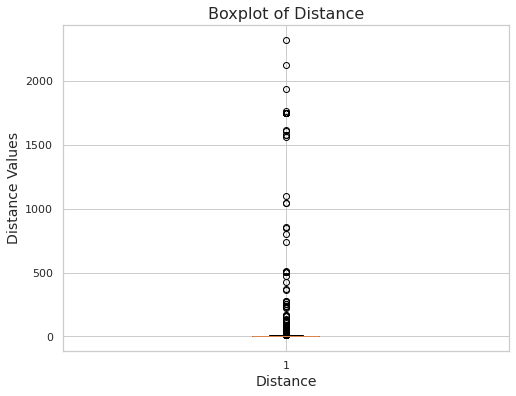

In [25]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data['distance'])

# Set labels and title
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Distance Values', fontsize=14)
plt.title('Boxplot of Distance', fontsize=16)

# Show plot
plt.show()


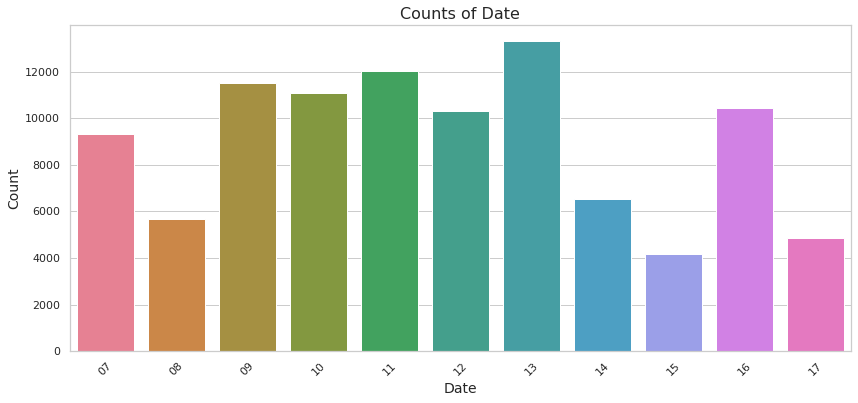

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create count plot
plt.figure(figsize=(14, 6))  # Adjust figsize as needed
sns.countplot(x="date", data=data, palette="husl")  # Adjust palette as needed

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Counts of Date', fontsize=16)

# Show plot
plt.show()


In [27]:
data.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,year,month,date,hour,distance,ride_minutes,pickup_cluster
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018,04,07,07,6.7,11.0,3
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018,04,07,07,2.2,4.0,17
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018,04,07,07,4.3,7.0,21
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018,04,07,07,6.5,11.0,0
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018,04,07,07,4.4,8.0,21


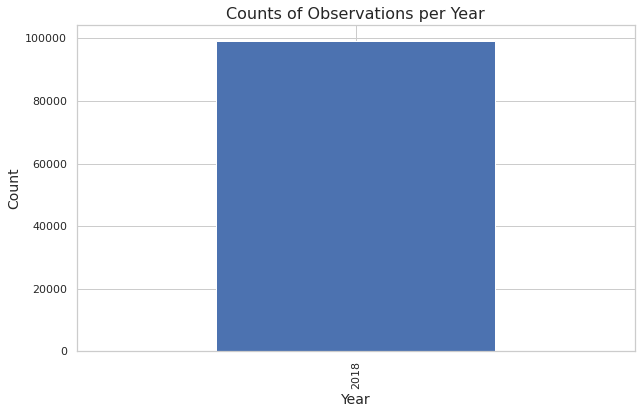

In [28]:
import matplotlib.pyplot as plt

# Count the occurrences of each year and create a bar plot
data['year'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))

# Set labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Counts of Observations per Year', fontsize=16)

# Show the plot
plt.show()


In [29]:
# Feature Engineering
def create_day_series(df):
    
    # Grouping by Date/Time to calculate number of trips
    day_df = pd.Series(df.groupby(['ts']).size())
    # setting Date/Time as index
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling to daily trips
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

day_df = create_day_series(data)
day_df.head()

ts
2018-04-07     9328
2018-04-08     5686
2018-04-09    11496
2018-04-10    11100
2018-04-11    12041
Freq: D, dtype: int64

In [30]:
day_df.shape

(11,)

Trend and Seasonality analysis

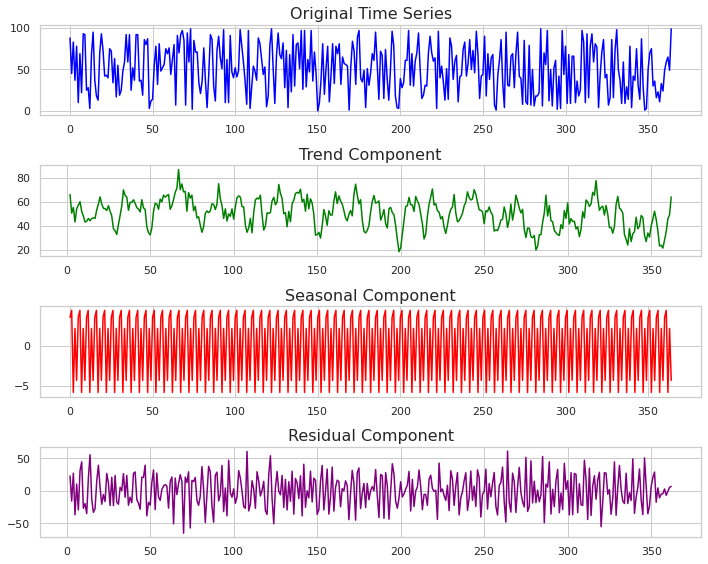

In [31]:
from random import randrange
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Generate some random data for demonstration
day_df = Series([randrange(100) for i in range(365)])

# Perform seasonal decomposition
result = seasonal_decompose(day_df, model='additive', freq=5)

# Plot the decomposed components with improved styling
plt.figure(figsize=(10, 8))

# Plot original time series
plt.subplot(4, 1, 1)
plt.plot(result.observed, color='blue')
plt.title('Original Time Series', fontsize=16)

# Plot trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='green')
plt.title('Trend Component', fontsize=16)

# Plot seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='red')
plt.title('Seasonal Component', fontsize=16)

# Plot residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='purple')
plt.title('Residual Component', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


From the above plot it is clear that there are both trend and seasonality in the data

## Time Series predictions using Holt-Winters

Holt-Winters is a model of time series behavior. Forecasting always requires a model, and Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality). Holt-Winters uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future

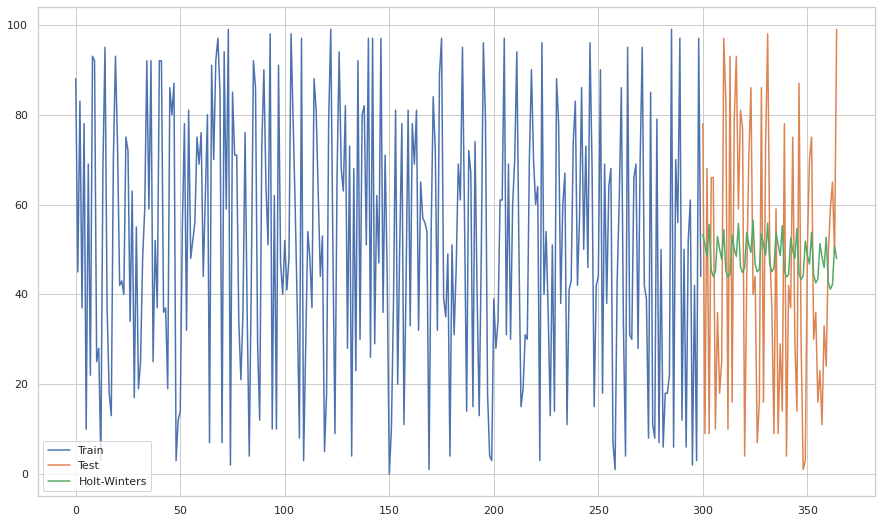

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
train, test = day_df.iloc[0:300], day_df.iloc[300:]
model = ExponentialSmoothing(day_df, seasonal='add', seasonal_periods=7).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])
plt.figure(figsize=(15,9))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')
plt.show()

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
mae = mean_absolute_error(test, pred)
print('MAE: %.3f' % mae)

MAE: 26.711


In [35]:
mape = mean_absolute_percentage_error(test, pred)
print('MAPE: %.3f' % mape)

MAPE: 226.998


## Fbprophet

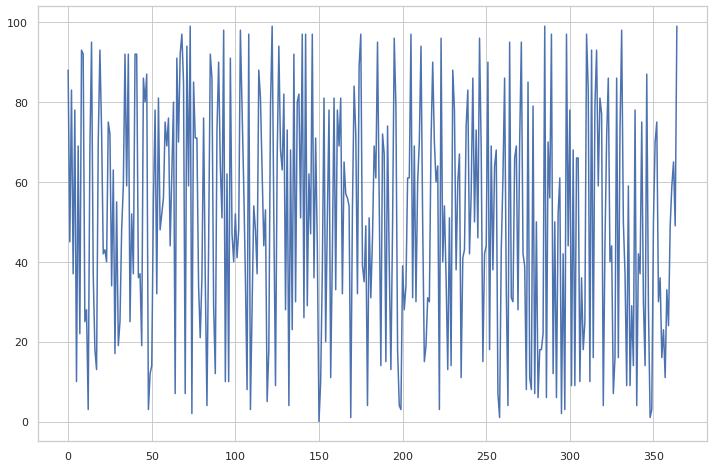

In [36]:
# plot the time series
plt.figure(figsize=(12,8))
day_df.plot()
plt.show()

We can clearly see the trend in rides over time and a monthly/yearly seasonal pattern to the ride counts. These are patterns we expect the forecast model to take into account.

In [37]:
# prepare expected column names
df = pd.DataFrame()
df['ds'] = day_df.index
df['y'] = day_df.values

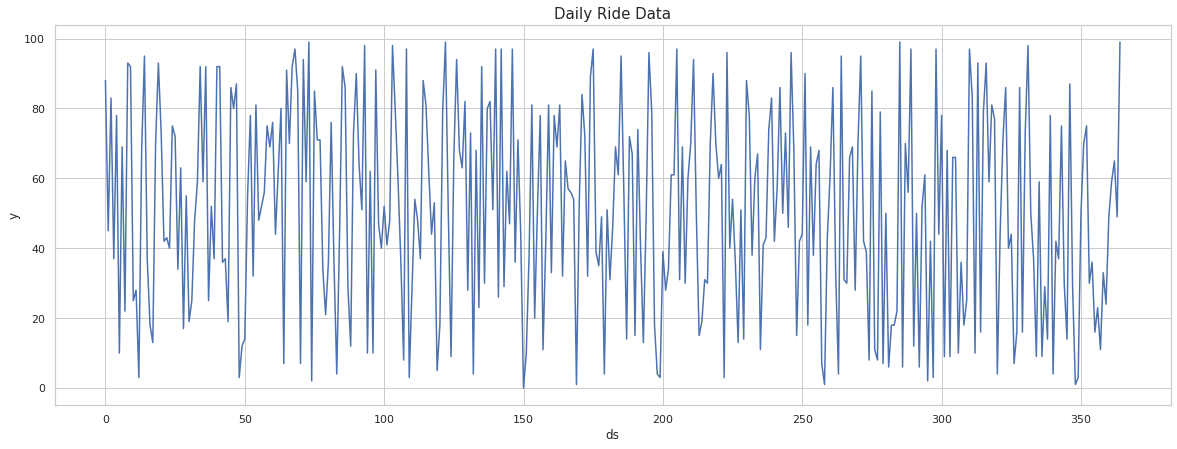

In [38]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="ds", y="y", data=df)
a.set_title("Daily Ride Data",fontsize=15)
plt.show()

In [39]:
from fbprophet import Prophet

# Step 1: Check the format of the date column and convert it if necessary
# Assuming your date column is named 'ds'
df['ds'] = pd.to_datetime(df['ds'])  # Convert to datetime if not already in datetime format

# Step 2: Check the range of date values and ensure they are valid

# Define the model
model = Prophet()

# Fit the model
model.fit(df)


## Manually Evaluate Forecast Model

In [40]:
# create test dataset, remove last 60 days
train = df.drop(df.index[:-60])
print(train.tail())

                               ds   y
360 1970-01-01 00:00:00.000000360  49
361 1970-01-01 00:00:00.000000361  59
362 1970-01-01 00:00:00.000000362  65
363 1970-01-01 00:00:00.000000363  49
364 1970-01-01 00:00:00.000000364  99


In [41]:
train.shape

(60, 2)

In [42]:
train['ds'] = pd.to_datetime(train['ds'])

In [43]:
forecast = model.predict(train)

In [44]:
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


                             ds       yhat  yhat_lower  yhat_upper
0 1970-01-01 00:00:00.000000305  46.067818    7.258064   83.221007
1 1970-01-01 00:00:00.000000306  46.033115    8.533403   85.061461
2 1970-01-01 00:00:00.000000307  45.998413    9.532590   79.590261
3 1970-01-01 00:00:00.000000308  45.963711    7.225042   83.224224
4 1970-01-01 00:00:00.000000309  45.929009    9.606809   84.607595


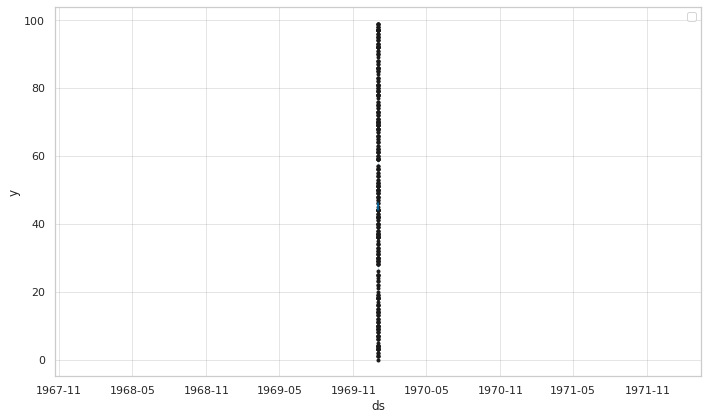

In [45]:
# plot forecast
model.plot(forecast)
plt.legend(loc='best')
plt.show()

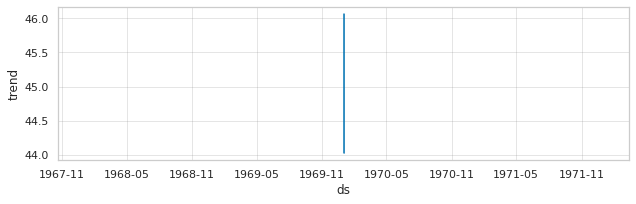

In [46]:
# Plot the components of the model
fig = model.plot_components(forecast)

In [47]:
forecast.shape

(60, 13)

In [48]:
# calculate MAE between expected and predicted values for december
y_true = df['y'][-60:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 25.986


In [49]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape)

MAPE: 218.399


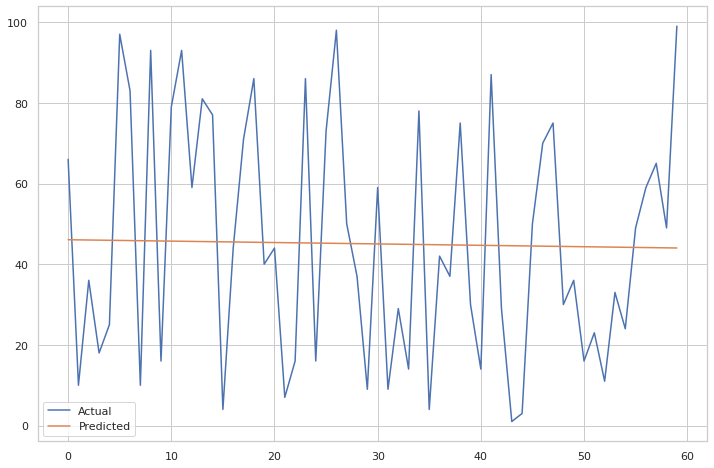

In [50]:
# plot expected vs actual
%matplotlib inline
plt.figure(figsize=(12,8))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()